# Gait Dynamics × Mental State Analysis

This notebook demonstrates how to find relationships between **gait dynamics** and **mental state scores** using demixed PCA approaches.

## Data Structure

```
Mental Scores: [n_subjects, n_mental_variables]  ← TIME-INVARIANT
    • One value per subject (constant throughout gait measurement)
    • Examples: wellbeing, anxiety, depression, stress, fatigue

Gait Dynamics: [n_subjects, n_timepoints, n_body_factors]  ← TIME-VARYING
    • Changes over gait cycle (0-100%)
    • Examples: hip_flexion, knee_flexion, stride_length, etc.
```

## Goal

Find: `mental_variables ↔ latent_gait_dynamics`

- Which gait patterns relate to wellbeing?
- Which gait patterns relate to anxiety?
- Can we predict mental state from gait?

In [1]:
# Setup
import sys
from pathlib import Path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.dpca import ContinuousScoreDPCA, MultiVariateMentalDPCA

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
print("Setup complete!")

Setup complete!


## 1. Generate Sample Data

### Gait Body Factors

In [2]:
# Parameters
np.random.seed(42)
n_subjects = 30
n_timepoints = 100
n_body_factors = 15
n_mental_vars = 5

# Gait body factor labels
gait_labels = [
    'hip_flexion', 'hip_abduction', 'knee_flexion', 'ankle_dorsiflexion',
    'pelvis_tilt', 'pelvis_obliquity', 'trunk_flexion', 'trunk_rotation',
    'stride_length', 'step_width', 'cadence', 'grf_vertical', 
    'grf_anterior', 'grf_lateral', 'com_velocity'
]

# Mental variable labels
mental_labels = ['wellbeing', 'anxiety', 'depression', 'stress', 'fatigue']

print("=== Gait Body Factors ===")
for i, label in enumerate(gait_labels):
    print(f"  {i:2d}. {label}")

=== Gait Body Factors ===
   0. hip_flexion
   1. hip_abduction
   2. knee_flexion
   3. ankle_dorsiflexion
   4. pelvis_tilt
   5. pelvis_obliquity
   6. trunk_flexion
   7. trunk_rotation
   8. stride_length
   9. step_width
  10. cadence
  11. grf_vertical
  12. grf_anterior
  13. grf_lateral
  14. com_velocity


### Generate Mental Scores (Time-Invariant)

In [3]:
# Generate correlated mental scores
# Shape: [n_subjects, n_mental_variables]
base_mental = np.random.randn(n_subjects)  # Latent factor

mental_scores = np.zeros((n_subjects, n_mental_vars))
mental_scores[:, 0] = 5 + base_mental * 1.5 + np.random.randn(n_subjects) * 0.5  # wellbeing (+)
mental_scores[:, 1] = 5 - base_mental * 1.2 + np.random.randn(n_subjects) * 0.5  # anxiety (-)
mental_scores[:, 2] = 5 - base_mental * 1.0 + np.random.randn(n_subjects) * 0.5  # depression (-)
mental_scores[:, 3] = 5 - base_mental * 0.8 + np.random.randn(n_subjects) * 0.5  # stress (-)
mental_scores[:, 4] = 5 - base_mental * 0.6 + np.random.randn(n_subjects) * 0.5  # fatigue (-)
mental_scores = np.clip(mental_scores, 0, 10)

print("=== Mental Scores ===")
print(f"Shape: {mental_scores.shape} = [n_subjects, n_mental_variables]")
print(f"\n⚠️  TIME-INVARIANT: One value per subject (constant during gait)")
print(f"\nExample (Subject 0):")
for label, val in zip(mental_labels, mental_scores[0]):
    print(f"  {label:12s}: {val:.2f}")

=== Mental Scores ===
Shape: (30, 5) = [n_subjects, n_mental_variables]

⚠️  TIME-INVARIANT: One value per subject (constant during gait)

Example (Subject 0):
  wellbeing   : 5.44
  anxiety     : 4.16
  depression  : 4.55
  stress      : 5.00
  fatigue     : 4.83


### Generate Gait Dynamics (Time-Varying)

In [4]:
# Generate gait dynamics
# Shape: [n_subjects, n_timepoints, n_body_factors]
gait_dynamics = np.zeros((n_subjects, n_timepoints, n_body_factors))
t = np.linspace(0, 2*np.pi, n_timepoints)

for i in range(n_subjects):
    for f in range(n_body_factors):
        # Time-dependent base pattern (gait cycle)
        base = np.sin(t + f * 0.5) + 0.5 * np.cos(2*t)
        
        # Mental-dependent effects (different mental vars affect different body factors)
        if f in [0, 2, 8, 14]:  # hip, knee, stride, com_velocity
            effect = 0.3 * (mental_scores[i, 0] - 5)  # wellbeing effect
        elif f in [4, 5, 6, 7]:  # pelvis, trunk
            effect = -0.2 * (mental_scores[i, 1] - 5)  # anxiety effect
        elif f in [10, 11, 12]:  # cadence, grf
            effect = -0.15 * (mental_scores[i, 4] - 5)  # fatigue effect
        else:
            effect = 0.1 * np.random.randn()
        
        gait_dynamics[i, :, f] = base + effect + np.random.randn(n_timepoints) * 0.1

print("=== Gait Dynamics ===")
print(f"Shape: {gait_dynamics.shape} = [n_subjects, n_timepoints, n_body_factors]")
print(f"\n⚠️  TIME-VARYING: Changes over gait cycle (0-100%)")

=== Gait Dynamics ===
Shape: (30, 100, 15) = [n_subjects, n_timepoints, n_body_factors]

⚠️  TIME-VARYING: Changes over gait cycle (0-100%)


## 2. Visualize Data

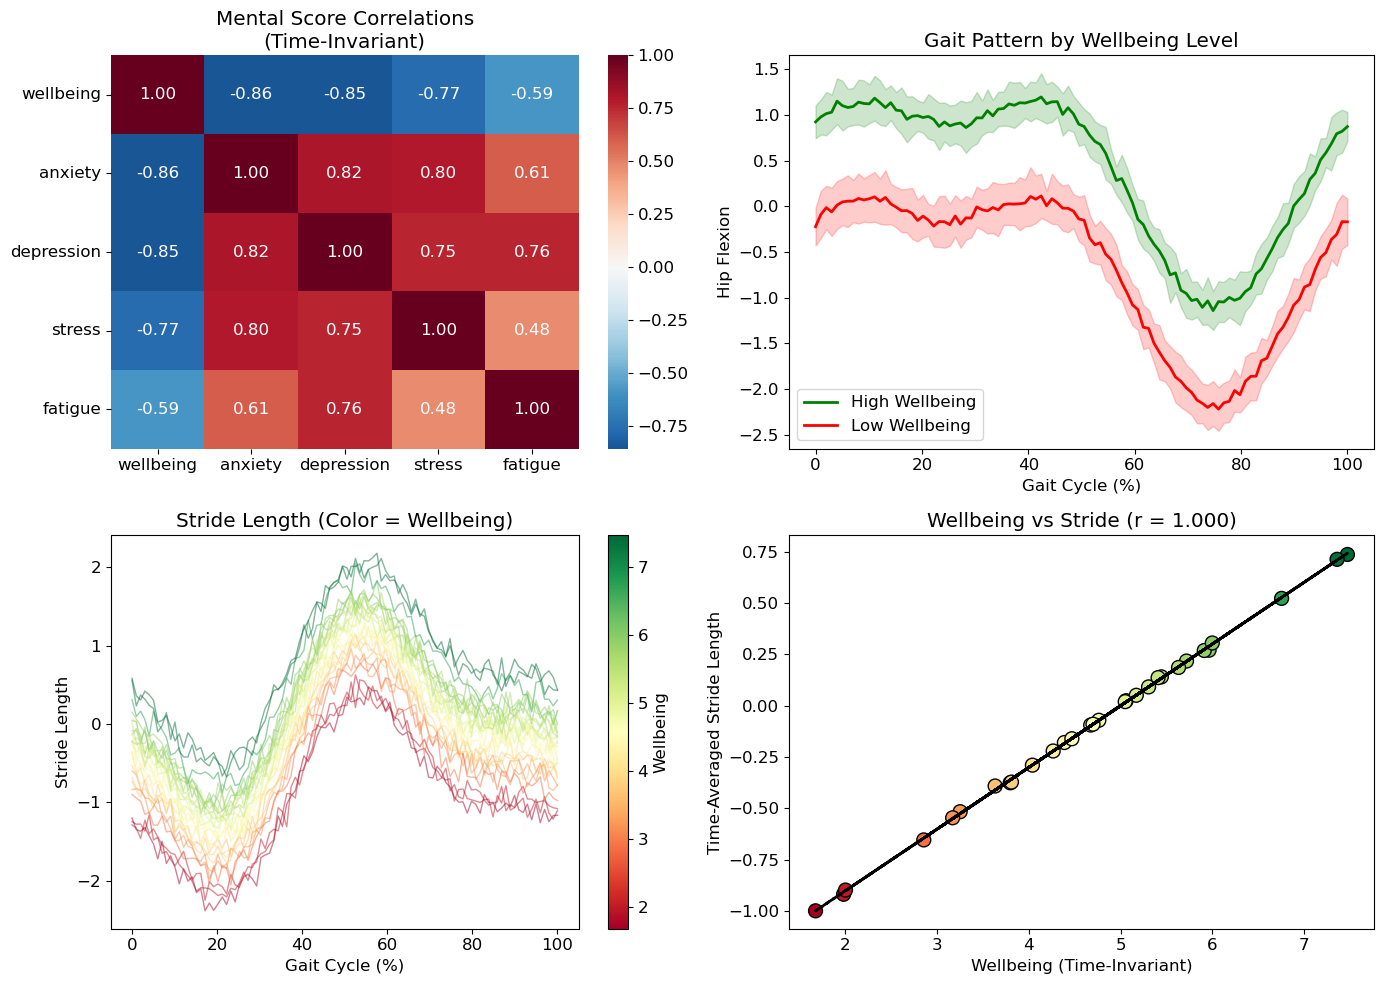

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
time_axis = np.linspace(0, 100, n_timepoints)

# 1. Mental score correlations
ax1 = axes[0, 0]
corr_matrix = np.corrcoef(mental_scores.T)
sns.heatmap(corr_matrix, xticklabels=mental_labels, yticklabels=mental_labels,
            cmap='RdBu_r', center=0, annot=True, fmt='.2f', ax=ax1)
ax1.set_title('Mental Score Correlations\n(Time-Invariant)')

# 2. Gait pattern by wellbeing level
ax2 = axes[0, 1]
high_wb = mental_scores[:, 0] > np.percentile(mental_scores[:, 0], 75)
low_wb = mental_scores[:, 0] < np.percentile(mental_scores[:, 0], 25)
ax2.plot(time_axis, gait_dynamics[high_wb, :, 0].mean(axis=0), 'g-', lw=2, label='High Wellbeing')
ax2.plot(time_axis, gait_dynamics[low_wb, :, 0].mean(axis=0), 'r-', lw=2, label='Low Wellbeing')
ax2.fill_between(time_axis, 
                  gait_dynamics[high_wb, :, 0].mean(axis=0) - gait_dynamics[high_wb, :, 0].std(axis=0),
                  gait_dynamics[high_wb, :, 0].mean(axis=0) + gait_dynamics[high_wb, :, 0].std(axis=0),
                  color='green', alpha=0.2)
ax2.fill_between(time_axis,
                  gait_dynamics[low_wb, :, 0].mean(axis=0) - gait_dynamics[low_wb, :, 0].std(axis=0),
                  gait_dynamics[low_wb, :, 0].mean(axis=0) + gait_dynamics[low_wb, :, 0].std(axis=0),
                  color='red', alpha=0.2)
ax2.set_xlabel('Gait Cycle (%)')
ax2.set_ylabel('Hip Flexion')
ax2.set_title('Gait Pattern by Wellbeing Level')
ax2.legend()

# 3. All subjects gait (color = wellbeing)
ax3 = axes[1, 0]
for i in range(n_subjects):
    color = plt.cm.RdYlGn((mental_scores[i, 0] - mental_scores[:, 0].min()) / 
                           (mental_scores[:, 0].max() - mental_scores[:, 0].min()))
    ax3.plot(time_axis, gait_dynamics[i, :, 8], color=color, alpha=0.5, lw=1)
sm = plt.cm.ScalarMappable(cmap='RdYlGn', 
                            norm=plt.Normalize(mental_scores[:, 0].min(), mental_scores[:, 0].max()))
sm.set_array([])
plt.colorbar(sm, ax=ax3, label='Wellbeing')
ax3.set_xlabel('Gait Cycle (%)')
ax3.set_ylabel('Stride Length')
ax3.set_title('Stride Length (Color = Wellbeing)')

# 4. Wellbeing vs time-averaged stride
ax4 = axes[1, 1]
stride_mean = gait_dynamics[:, :, 8].mean(axis=1)
ax4.scatter(mental_scores[:, 0], stride_mean, c=mental_scores[:, 0], cmap='RdYlGn', 
            s=100, edgecolors='black')
z = np.polyfit(mental_scores[:, 0], stride_mean, 1)
ax4.plot(mental_scores[:, 0], np.poly1d(z)(mental_scores[:, 0]), 'k--', lw=2)
corr = np.corrcoef(mental_scores[:, 0], stride_mean)[0, 1]
ax4.set_xlabel('Wellbeing (Time-Invariant)')
ax4.set_ylabel('Time-Averaged Stride Length')
ax4.set_title(f'Wellbeing vs Stride (r = {corr:.3f})')

plt.tight_layout()
plt.show()

## 3. Analysis: MultiVariateMentalDPCA

This class finds relationships between multiple mental variables and gait latent dynamics using CCA (Canonical Correlation Analysis) or PLS (Partial Least Squares).

```
[Subjects, mental_variables] ↔ [Subjects, time, body_factors]
```

In [6]:
# Fit MultiVariateMentalDPCA
model = MultiVariateMentalDPCA(
    n_gait_components=10,
    method='cca'  # or 'pls'
)

model.fit(
    gait_dynamics,      # [n_subjects, n_timepoints, n_body_factors]
    mental_scores,      # [n_subjects, n_mental_variables]
    gait_labels=gait_labels,
    mental_labels=mental_labels
)

print("=== Model Fitted ===")
print(f"Method: {model.method.upper()}")
print(f"Gait latent components: {model.gait_latent_.shape[1]}")
print(f"Mental variables: {len(mental_labels)}")
print(f"\nCanonical correlations:")
for i, corr in enumerate(model.correlations_):
    bar = "█" * int(abs(corr) * 20)
    print(f"  Component {i+1}: {corr:.3f} {bar}")

=== Model Fitted ===
Method: CCA
Gait latent components: 10
Mental variables: 5

Canonical correlations:
  Component 1: 1.000 ███████████████████
  Component 2: 0.999 ███████████████████
  Component 3: 0.999 ███████████████████
  Component 4: 0.619 ████████████
  Component 5: 0.422 ████████


### Results: Mental → Gait Associations

In [7]:
# Get associations
associations = model.get_mental_gait_associations()

print("=== Mental Variable → Gait Feature Associations ===\n")
for mental_var, gait_assoc in associations.items():
    print(f"{mental_var.upper()}:")
    for gait_feat, corr in gait_assoc.items():
        direction = "↑" if corr > 0 else "↓"
        bar = "█" * int(abs(corr) * 30)
        print(f"  {gait_feat:22s}: {corr:+.3f} {bar} {direction}")
    print()

=== Mental Variable → Gait Feature Associations ===

WELLBEING:
  stride_length         : +1.000 █████████████████████████████ ↑
  hip_flexion           : +1.000 █████████████████████████████ ↑
  com_velocity          : +1.000 █████████████████████████████ ↑
  knee_flexion          : +1.000 █████████████████████████████ ↑
  trunk_rotation        : +0.863 █████████████████████████ ↑

ANXIETY:
  pelvis_tilt           : -0.999 █████████████████████████████ ↓
  trunk_rotation        : -0.999 █████████████████████████████ ↓
  pelvis_obliquity      : -0.999 █████████████████████████████ ↓
  trunk_flexion         : -0.999 █████████████████████████████ ↓
  com_velocity          : -0.859 █████████████████████████ ↓

DEPRESSION:
  com_velocity          : -0.855 █████████████████████████ ↓
  hip_flexion           : -0.855 █████████████████████████ ↓
  knee_flexion          : -0.851 █████████████████████████ ↓
  stride_length         : -0.851 █████████████████████████ ↓
  pelvis_obliquity      : -

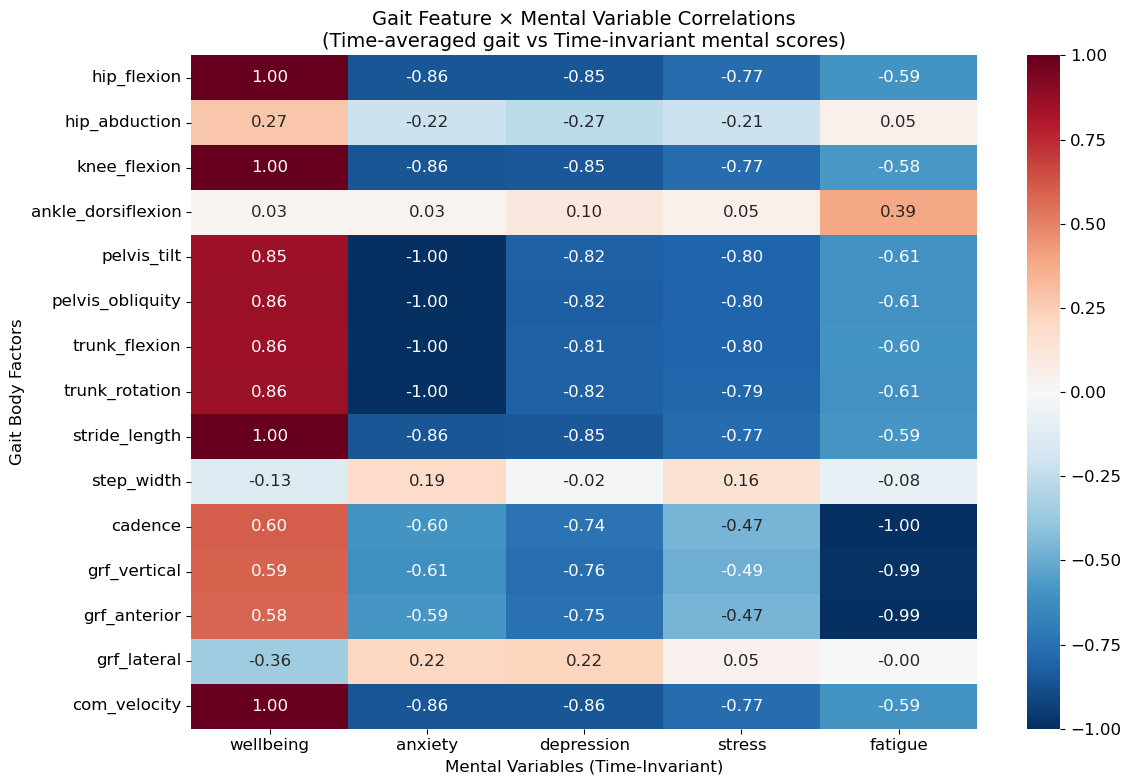


Interpretation:
  Red (+): Higher mental score → Higher gait feature value
  Blue (-): Higher mental score → Lower gait feature value


In [8]:
# Heatmap of correlations
plt.figure(figsize=(12, 8))
sns.heatmap(
    model.feature_correlations_,
    xticklabels=mental_labels,
    yticklabels=gait_labels,
    cmap='RdBu_r',
    center=0,
    annot=True,
    fmt='.2f',
    vmin=-1, vmax=1
)
plt.title('Gait Feature × Mental Variable Correlations\n(Time-averaged gait vs Time-invariant mental scores)', fontsize=14)
plt.xlabel('Mental Variables (Time-Invariant)')
plt.ylabel('Gait Body Factors')
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("  Red (+): Higher mental score → Higher gait feature value")
print("  Blue (-): Higher mental score → Lower gait feature value")

## 4. Single Variable Analysis: ContinuousScoreDPCA

When you have only **one** mental variable (e.g., wellbeing), use `ContinuousScoreDPCA`.

In [9]:
# Prepare data for ContinuousScoreDPCA
# Reshape: [n_subjects, n_timepoints, n_features] → [n_subjects, n_features, n_timepoints]
gait_for_single = gait_dynamics.transpose(0, 2, 1)  # [30, 15, 100]
wellbeing_scores = mental_scores[:, 0]  # [30,]

single_model = ContinuousScoreDPCA(n_components=5)
single_model.fit(
    gait_for_single,    # [n_subjects, n_features, n_timepoints]
    wellbeing_scores,   # [n_subjects,]
    feature_labels=gait_labels
)

print("=== ContinuousScoreDPCA Results ===")
print(f"\nTop 5 Gait Features Associated with Wellbeing:")
print("-" * 60)
summary = single_model.summary()
for feature, weight in summary['top_score_related_features']:
    direction = "↑ Higher wellbeing → Increase" if weight > 0 else "↓ Higher wellbeing → Decrease"
    bar = "█" * int(abs(weight) * 20)
    print(f"  {feature:22s} | {weight:+.3f} | {bar:20s} {direction}")

=== ContinuousScoreDPCA Results ===

Top 5 Gait Features Associated with Wellbeing:
------------------------------------------------------------
  knee_flexion           | +0.436 | ████████             ↑ Higher wellbeing → Increase
  com_velocity           | +0.435 | ████████             ↑ Higher wellbeing → Increase
  stride_length          | +0.434 | ████████             ↑ Higher wellbeing → Increase
  hip_flexion            | +0.434 | ████████             ↑ Higher wellbeing → Increase
  trunk_rotation         | +0.203 | ████                 ↑ Higher wellbeing → Increase


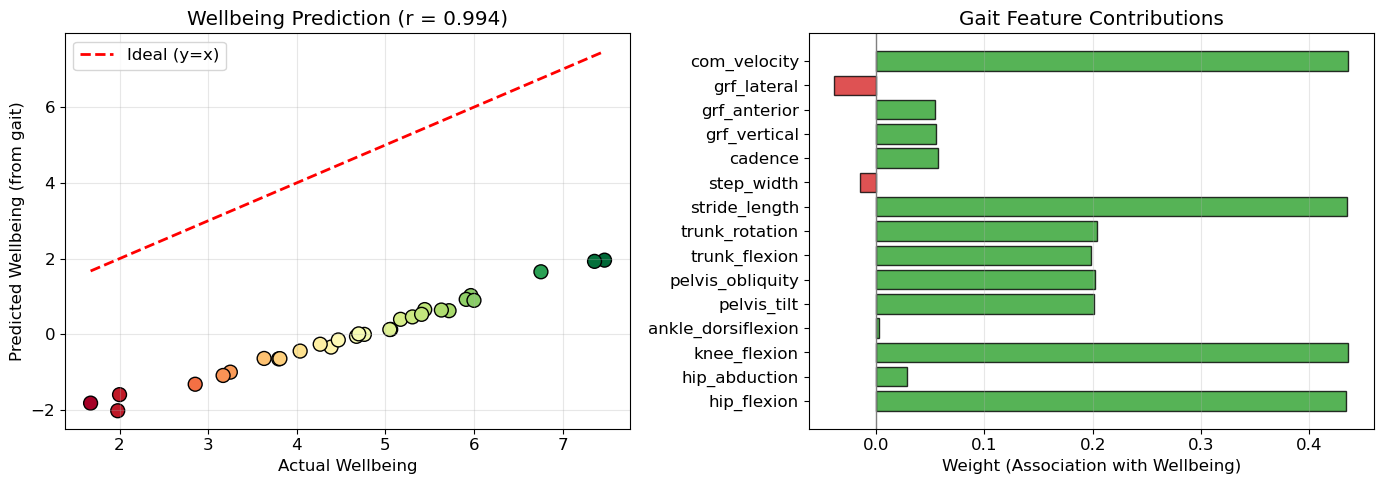

In [10]:
# Predict wellbeing from gait
predicted = single_model.predict_score(gait_for_single)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Actual vs Predicted
ax1 = axes[0]
ax1.scatter(wellbeing_scores, predicted, c=wellbeing_scores, cmap='RdYlGn', s=100, edgecolors='black')
ax1.plot([wellbeing_scores.min(), wellbeing_scores.max()], 
         [wellbeing_scores.min(), wellbeing_scores.max()], 'r--', lw=2, label='Ideal (y=x)')
corr = np.corrcoef(wellbeing_scores, predicted)[0, 1]
ax1.set_xlabel('Actual Wellbeing')
ax1.set_ylabel('Predicted Wellbeing (from gait)')
ax1.set_title(f'Wellbeing Prediction (r = {corr:.3f})')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Feature weights
ax2 = axes[1]
weights = single_model.score_weights_
colors = ['#2ca02c' if w > 0 else '#d62728' for w in weights]
ax2.barh(np.arange(len(weights)), weights, color=colors, alpha=0.8, edgecolor='black')
ax2.set_yticks(np.arange(len(weights)))
ax2.set_yticklabels(gait_labels)
ax2.set_xlabel('Weight (Association with Wellbeing)')
ax2.set_title('Gait Feature Contributions')
ax2.axvline(x=0, color='gray', lw=1)
ax2.grid(True, axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Summary

### Data Structure

| Data | Shape | Time Dependency |
|------|-------|-----------------|
| Mental Scores | `[n_subjects, n_mental_vars]` | ❌ TIME-INVARIANT (constant per subject) |
| Gait Dynamics | `[n_subjects, n_timepoints, n_body_factors]` | ✅ TIME-VARYING (gait cycle) |

### Available Classes

| Class | Use Case | Mental Shape | Gait Shape |
|-------|----------|--------------|------------|
| `MultiVariateMentalDPCA` | Multiple mental variables | `(n_subjects, n_mental)` | `(n_subjects, n_time, n_body)` |
| `ContinuousScoreDPCA` | Single mental variable | `(n_subjects,)` | `(n_subjects, n_features, n_time)` |

### Applications

- **Mental health monitoring**: Estimate wellbeing/anxiety from gait patterns
- **Early detection**: Detect mental state changes through gait analysis
- **Rehabilitation**: Objective evaluation of intervention effects
- **Research**: Understand mind-body connections